In [1]:
from IPython.display import display, HTML

display(HTML(data="""

<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

%reload_ext jupyternotify

#%notify

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import sys

import qutip as qtp

import matplotlib.pyplot as plt
from pathlib import Path

from scipy import linalg as la
from scipy.optimize import minimize

parent_path = ".."  #str(Path(__file__).resolve().parents[1])
sys.path.append(parent_path)

import pysqkit


import time
import datetime
import os

from pysqkit.solvers.solvkit import integrate
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib notebook
plt.rcParams['figure.figsize'] = (10, 7)

In [3]:
import pysqkit.tomography.utilsTomo as tomo  #instead of sections 1 and 2

# from pysqkit.tomography.utilsTomo import * #prend pas les fct en _ (ex: les _bra, _rho...)

# Util and Tomography (in utilsTomo)

## Utils

In [ ]:
def n_th(maxs, n):  #returns n-th tuple with the i_th term varying between 0 and maxs[i]
    temp = np.zeros(len(maxs))
    for i in range(0, len(temp)):
        temp[i] = (n//np.prod(maxs[i+1:]))%np.prod(maxs[i])
    
    res = [int(k) for k in temp]
    return res

# nb_levels = [1, 1, 5, 1, 1, 1, 2]
# for i in range(np.prod(nb_levels)):
#     print(n_th(nb_levels, i))

In [ ]:
def ket(n, **kwargs):
    return  qtp.fock(kwargs['nb_levels'], n_th(kwargs['nb_levels'], n))

def bra(m, **kwargs):
    return qtp.fock(kwargs['nb_levels'], n_th(kwargs['nb_levels'], m)).dag()

def rho_nm(n, m, **kwargs): 
    return ket(n, **kwargs)*bra(m, **kwargs)

In [ ]:
#defining gates
def gate_from_Kraus(state_init, **kwargs):
    ''' **kwargs should contain at least 'op_list' a list of Kraus operators '''
    
    if state_init.type == "ket": 
        print("Initial state has been transformed into a density matrix")
        state_init = state_initnit * state_init.dag()
    
    res = qtp.Qobj(np.zeros(state_init.shape), dims = state_init.dims)
    for op in kwargs['op_list']:
        assert isinstance(op, qtp.Qobj)
        res+= op*state_init*op.dag()
    
    return res


def gate_from_U(state_init, **kwargs): #function that applies the gate described by the unitary matrix U
    ''' **kwargs should contain at least 'U' the unitary operator describing the gate '''
    U = kwargs['U']
    
    if state_init.type == "ket": 
        return qtp.Qobj(U) * state_init
    elif state_init.type == "oper":
        return qtp.Qobj(U) * state_init * qtp.Qobj(U).dag()
    else :
        print("Type of state_init not recognized, must be ket or oper")
    

### Color maps

In [ ]:
def draw_mat(mat, mat_name, vmin = np.NaN, vmax = np.NaN):
    
    if np.isnan(vmin):
        vmin = min(np.min(mat.real), np.min(mat.imag))
    if np.isnan(vmax):
        vmax = np.max([np.max(mat.real), np.max(mat.imag)])
    fig, ax = plt.subplots(1, 3, figsize = (12,5))

    im0 = ax[0].imshow(np.abs(mat), vmin=vmin, vmax=vmax)
    ax[0].set_title("$| "+ mat_name + "_{ij} |$")
    ax[0].set_xlabel('$i$')
    ax[0].set_ylabel('$j$')


    im1 = ax[1].imshow(mat.real, vmin=vmin, vmax=vmax)
    ax[1].set_title("$Re(  "+ mat_name + "_{ij} )$")
    ax[1].set_xlabel('$i$')
    ax[1].set_ylabel('$j$')


    im2 = ax[2].imshow(mat.imag, vmin=vmin, vmax=vmax)
    ax[2].set_title("$Im(  "+ mat_name + "_{ij} )$")
    ax[2].set_xlabel('$i$')
    ax[2].set_ylabel('$j$')

    fig.colorbar(im2, ax=ax.ravel().tolist(), orientation = 'horizontal')
    
    
def draw_mat_mult(mat_list, mat_name_list, vmin = np.NaN, vmax = np.NaN):
    fig, ax = plt.subplots(len(mat_list), 3, figsize = (12,4*len(mat_list)))
    
    for i in range(len(mat_list)):
        
        if np.isnan(vmin):
            vmin = min(np.min(mat_list[i].real), np.min(mat_list[i].imag))
        if np.isnan(vmax):
            vmax = np.max([np.max(mat_list[i].real), np.max(mat_list[i].imag)])
            
        
        im0 = ax[i, 0].imshow(np.abs(mat_list[i]), vmin=vmin, vmax=vmax)
        ax[i, 0].set_title("$| "+ mat_name_list[i] + "_{ij} |$")
        ax[i, 0].set_xlabel('$i$')
        ax[i, 0].set_ylabel('$j$')


        im1 = ax[i, 1].imshow(mat_list[i].real, vmin=vmin, vmax=vmax)
        ax[i, 1].set_title("$Re(  "+ mat_name_list[i] + "_{ij} )$")
        ax[i, 1].set_xlabel('$i$')
        ax[i, 1].set_ylabel('$j$')


        ax[i, 2].imshow(mat_list[i].imag, vmin=vmin, vmax=vmax)
        ax[i, 2].set_title("$Im(  "+ mat_name_list[i] + "_{ij} )$")
        ax[i, 2].set_xlabel('$i$')
        ax[i, 2].set_ylabel('$j$')

        fig.colorbar(im0, ax=ax[i, :].ravel().tolist(), orientation = 'vertical')


### Fourier

In [ ]:
def flat_top(N):

    """
    See: https://en.wikipedia.org/wiki/Window_function#Flat_top_window
    """

    n = np.arange(N)

    a_0 = 0.21557895
    a_1 = 0.41663158
    a_2 = 0.277263158
    a_3 = 0.083578947
    a_4 = 0.006947368

    w_n = (+a_0
           -a_1*np.cos(2*np.pi*n/N)
           +a_2*np.cos(4*np.pi*n/N)
           -a_3*np.cos(6*np.pi*n/N)
           +a_4*np.cos(8*np.pi*n/N))

    return w_n/np.mean(w_n)



def fourier(phi_t, t, f_min, f_max, n_zero_padding=0, door_func=None, real=True):

    """
    Custom fourier function to perform proper spectral analysis according to my needs.
    Return the fourier transform of the signal, as well as the frequencices array.
    args:
        phi_t: the time fonction, 1D array of length n
        t: evenly sampeled time array, 1D array of length n
        f_min: fraction of the time signal at which to start
        f_max: fraction of the time signal at which to end
        n_zero_padding: the number of time we zero pad the signal
        door_func: the door function to us with the zero padding
        real: do we return only the first half of the FT
    return:
        phi_w: the frequency representation of the signal
        w: the evenly sampled frequency array
    """

    if(door_func is None):
        door_func = lambda x:1

    n_max = int(len(t)*f_max)
    n_min = int(len(t)*f_min)
    n = n_max - n_min
    dt = t[1]-t[0]
    f_t = door_func(n)

    if(n_zero_padding == 0):
        phi_t = phi_t[n_min:n_max]
    else:
        phi_t = np.concatenate([
            phi_t[n_min:n_max]*(n_zero_padding+1)*f_t, np.zeros((n_zero_padding*n))])
    n = n*(n_zero_padding+1)

    dw = 2*np.pi/(dt*n)

    if(real):
        w = np.arange(0, n//2)*dw
        phi_w = np.abs(2 * np.fft.fft(phi_t)[:n//2]/n)
    else:
        w = np.arange(0, n)*dw
        phi_w = np.fft.fft(phi_t)[:n]/n

    return phi_w, w

## Tomography

We take the following convention : 
$$\text{The } \left\{ \rho_i \right\} \text{ are the } \left|n\right>\left<m\right| \text{ ; } n,m \in [\![0, \text{d} ]\!]^2 $$
$$ \text{For 2 systems : the } \left\{ \left|n\right> \right\} \text{are the} \left|ab\right> \text{ ; } a,b \in [\![0, \textit{nb_levels}[0] ]\!] \times [\![0, \textit{nb_levels}[1] ]\!] $$

 
R) d is the total number of levels : $d = \prod _{i} \textit{nb_levels}[i]$ 
In the case of quBits, $d = 2^n$ with $n$ being the number of qubits in the system.  \
For quDits having k levels, it is $d = k^n$



R) There are $d^2$ terms in the $\left\{\rho_i\right\}$ family and each of them has $d^2$ components

In [ ]:
def n_th(maxs, n):  #returns n-th tuple with the i_th term varying between 0 and maxs[i]
    temp = np.zeros(len(maxs))
    for i in range(0, len(temp)):
        temp[i] = (n//np.prod(maxs[i+1:]))%np.prod(maxs[i])
    
    res = [int(k) for k in temp]
    return res

# nb_levels = [1, 1, 5, 1, 1, 1, 2]
# for i in range(np.prod(nb_levels)):
#     print(n_th(nb_levels, i))

### $\{ \rho_i \}$

In [ ]:
def ket(n: int, 
        nb_levels: Union[int, Iterable[int]] ):
    '''nb_levels is an int or a list of the number of levels of each system'''
    if isinstance(nb_levels, int):
        nb_levels = [nb_levels]
    return  qtp.fock(nb_levels, n_th(nb_levels, n))

def bra(m,
        nb_levels: Union[int, Iterable[int]] ):
    '''nb_levels is an int or a list of the number of levels of each system'''
    if isinstance(nb_levels, int):
        nb_levels = [nb_levels]
    return  qtp.fock(nb_levels, n_th(nb_levels, m)).dag()   
     
def rho_nm(n, m,
           nb_levels: Union[int, Iterable[int]] ):
    '''nb_levels is an int or a list of the number of levels of each system'''
    if isinstance(nb_levels, int):
        nb_levels = [nb_levels]
    return ket(n, nb_levels)*bra(m, nb_levels)

def rho_nm_flat(j, 
                nb_levels: Union[int, Iterable[int]] ):
    '''nb_levels is an int or a list of the number of levels of each system'''
    
    if isinstance(nb_levels, int):
        nb_levels = [nb_levels]
    d = np.prod(nb_levels)
            
    n, m = n_th([d,d], j)
    
    return rho_nm(n,m, nb_levels)
    

def basis_rho_nm(nb_levels: Union[int, Iterable[int]] ):
    '''nb_levels is an int or a list of the number of levels of each system'''
    if isinstance(nb_levels, int):
        nb_levels = [nb_levels]
    d = np.prod(nb_levels)
    
    res = []
    for k in range(d**2):
        res.append(rho_nm_flat(k , nb_levels))

    return res 
    
    

# lA = 5
# lB = 5
# basis_rho_nm(**{'nb_levels_A':lA , 'nb_levels_B' :lB, 'd' : lA*lB})

    

### $\{ \tilde{E_i} \}$

We take the following convention : \
$\{\tilde{E_i} \}$ is the basis for operators. There are $d^2$ of them and each has $d^2$ components.

Usually when there are 2 levels, we take Pauli matrices and tensor product of pauli matrices. \
For higher levels we will use Generalized Gell-Mann matrices.

If $P_j ; (j=1...d)$ is the basis for a L levels qudit then ($d=L^2$) : 
$$\forall i \in [\![1, d^2 ]\!] , \exists! j,k \in [\![1, d]\!]^2 \text{ so that } \tilde{E_i} = P_j\otimes P_k$$


In [ ]:
def Pauli_gen(j, local_d):#operator P_j for 1 system
    
    if j >= local_d**2:
        print("indice demandé trop grand pour la dimension locale précisée")
        return None
    
    a1 = j//local_d
    a2 = j%local_d

    if a1<a2:
        res = np.zeros((local_d, local_d))*0j
        res[a1,a2] = 1
        res[a2,a1] = 1
        return qtp.Qobj(res)

    elif a1>a2:
        res = np.zeros((local_d, local_d))*0j
        res[a1,a2] = 1j
        res[a2,a1] = -1j
        return qtp.Qobj(res)

    else:#a1=a2
        if a1==0:
            return qtp.qeye(local_d)

        elif a1<(local_d-1):
            res = np.zeros((local_d, local_d))*0j
            h_k_lvl_inf = Pauli_gen(a1*(local_d-1) + a2, local_d-1)  #we take one at same coordinates in lower level basis
            res[:-1, :-1] = h_k_lvl_inf.full()
            return qtp.Qobj(res)

        else : #a1 = a2 = lvls-1
            res = np.zeros((local_d, local_d))*0j
            res[:-1, :-1] = qtp.qeye(local_d-1).full()
            res[-1, -1] = 1-local_d
            res = np.sqrt(2/(local_d*(local_d-1)))*res
            return qtp.Qobj(res)
        
    
def E_tilde_pauli(i, **kwargs):
    pauli_list = []
    
    pauli_maxs = [int(max_lvl**2) for max_lvl in kwargs['nb_levels']]
    
    tpl = n_th(pauli_maxs, i) #tuple of indices of the P_i that will appear in the product defining E_tilde 
                              #(as in sigma_i x sigma_j x sigma_k)
                              #For L levels, there are L^2 pauli_gen matrices
    for j in range(len(tpl)):
        ind = tpl[j]
        pauli_list.append(Pauli_gen(ind, kwargs['nb_levels'][j]))
        
    return qtp.tensor(pauli_list)
                           
def basis_E_tilde_pauli(**kwargs):
    res = []
    for i in range(kwargs['d']**2):
        res.append(E_tilde_pauli(i , **kwargs))

    return res

## Sanity check                           
# dic_test = {
#     'nb_levels' : [3,4,5],
# }
# dic_test['d'] =  np.prod(dic_test['nb_levels'])

# E_tilde_pauli(15, **dic_test)

# #Orthogonality test
# dic_test = {
#     'nb_levels' : [2,2],
# }
# dic_test['d'] =  np.prod(dic_test['nb_levels'])

# for i in range(dic_test['d']**2):
#     for j in range(dic_test['d']**2):
#         print((i,j), np.trace(E_tilde_pauli(i, **dic_test).full().dot(E_tilde_pauli(j, **dic_test).dag().full())))

### $\textit{fct_to_lambda(...)}$

Now we will use the following conventions : 
$$\lambda \in d^2 \times d^2 \text{ is the matrix defined by : } \mathcal{E} (\rho_j) = \sum_k \lambda_{jk} \rho_k \text{    ($\mathcal{E}$ is the gate)}$$

In [ ]:
def fct_to_lambda(fct, 
                    nb_levels: Union[int, Iterable[int]],
                    base_rho="nm", 
                    draw_lambda = False, 
                    **kwargs):
    ''' 'fct' takes an initial state and kwargs and returns the output state'''
                    
    if isinstance(nb_levels, int):
        nb_levels = [nb_levels]
    d = np.prod(nb_levels)
    
    #set the basis
    if base_rho != "nm":
        print("This base_rho is non treated, instead took default basis of |n><m|")
    rho = rho_nm #functions to calculate each term
    rho_flat = rho_nm_flat
            
            
    #function to calculate rho_primes
    def rho_prime(n,m):
        if n == m:
            return fct(rho(n, m, nb_levels), **kwargs)
        else :
            n_n = rho(n, n, nb_levels)
            m_m = rho(m, m, nb_levels)
            
            plus = (ket(n, nb_levels) + ket(m, nb_levels)).unit()
            plus_plus = plus * plus.dag()
            
            minus = (ket(n, nb_levels) +  1j*ket(m, nb_levels)).unit()
            minus_minus = minus * minus.dag()

            n_n_prime = fct(n_n, **kwargs)
            m_m_prime = fct(m_m, **kwargs)
            plus_plus_prime = fct(plus_plus, **kwargs)
            minus_minus_prime = fct(minus_minus, **kwargs)

            return plus_plus_prime + 1j*minus_minus_prime - (1+1j)/2 * n_n_prime - (1+1j)/2 * m_m_prime

            
    #skeleton
    lambda_mat = np.zeros((d**2, d**2))*1j

    #filling
    for i in range(d**2):
        n_i, m_i = n_th([d,d], i)
        
        rho_prime_i = rho_prime(n_i, m_i)
            
            
        for j in range(d**2):
            n_j, m_j = n_th([d,d], j)
            
            lambda_mat[i,j] = np.trace(rho_prime_i.full().dot(
                                             rho(n_j, m_j, nb_levels).dag().full())  
                                       )
            
    if draw_lambda:
        draw_mat(lambda_mat, "\lambda")  
        
    return lambda_mat

# deb = time.time()
# lambda_mat = fct_to_lambda(gate_fct, **param)
# print("Ca a pris ", time.time() - deb, "secondes")


# plt.figure()
# plt.imshow(np.abs(lambda_mat))
# plt.colorbar()
# plt.title("$| \lambda_{ij} |$")
# plt.xlabel('$i$')
# plt.ylabel('$j$')

### $\textit{lambda_to_chi(...)}$

The $\chi$ matrix for a basis $\left\{ \tilde{E_i} \right\}$ of operators by the following formula :

$$\mathcal{E}(\rho) = \sum_{mn} \chi_{mn} \tilde{E_m}\rho\tilde{E_n}^\dagger$$

Some examples of $\chi$ matrices :

For 1 qubits : X operator $$\chi_X = \begin{bmatrix}
0 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0
\end{bmatrix}$$

For 2 qubits : $U_{CNOT} = I\otimes I + I\otimes X + Z\otimes I - Z\otimes Z$ donc : 
$$\chi_{CNOT} = \begin{bmatrix}
 1 &  1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  1 & -1 & 0 & 0 \\
 1 &  1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  1 & -1 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 1 &  1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  1 & -1 & 0 & 0 \\
-1 & -1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 &  1 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0 \\
 0 &  0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 &  0 &  0 & 0 & 0
\end{bmatrix}$$

In [ ]:
def lambda_to_chi(lambda_mat, 
                    nb_levels: Union[int, Iterable[int]], 
                    base_E_tilde="Pauli gen", 
                    draw_chi = False):
                        
    ''' 'nb_levels' is an int or a list of the number of levels of each system'''
                    
    if isinstance(nb_levels, int):
        nb_levels = [nb_levels]
                        
    #set the basis
    if base_E_tilde != "Pauli gen":
        print("This base_E_tilde is non treated, instead took default basis of Pauli-like operators")
    basis_E_tilde = basis_E_tilde_pauli(nb_levels)
    
    lambda_qobj = qtp.Qobj(lambda_mat)
    chi_mat = qtp.qpt(lambda_qobj, [basis_E_tilde])
      
    if draw_chi:
        draw_mat(chi_mat, "\chi")

    return chi_mat

# deb = time.time()
# chi_mat = lambda_to_chi(lambda_mat, **param)
# print("Ca a pris ", time.time() - deb, "secondes")


# plt.figure()
# plt.imshow(np.abs(chi_mat))
# plt.colorbar()
# plt.title("$| \chi_{ij} |$")
# plt.xlabel('$i$')
# plt.ylabel('$j$')

### $\textit{chi_to_kraus(...)}$

We use the formula 8.168 from Nielsen and Chuang : 

$$ E_i = \sqrt{d_i}\sum_j U_{ij} \tilde{E_j}$$ 

$$ \text{  with  } U \text{  such that  } \chi = UDU^\dagger \text{ ; } U \text{ unitary and } D \text{ diagonal }$$

In [ ]:
def chi_to_kraus(chi_mat, 
                 nb_levels: Union[int, Iterable[int]], 
                 base_E_tilde="Pauli gen", 
                 draw_kraus = False):
    
    if isinstance(nb_levels, int):
        nb_levels = [nb_levels]
    d = np.prod(nb_levels)
    
    #set the basis
    if base_E_tilde != "Pauli gen":
        print("This base_E_tilde is non treated, instead took default basis of Pauli-like operators")
    basis_E_tilde = basis_E_tilde_pauli(nb_levels)
    
    D, U = la.eigh(chi_mat)
    U = U
    
    res = []
    for i in range(len(D)):
        if np.abs(D[i]) > 10**(-9): #we discard null eigenvalues
            res.append(qtp.Qobj(np.zeros((d,d)), dims = [nb_levels, nb_levels]))
            for j in range(len(basis_E_tilde)):
                    res[-1]+= np.sqrt(D[i])* U[j,i] * basis_E_tilde[j]
                    
    
    if draw_kraus:
        if len(res) == 1:
            draw_mat(res[0].full(), "E^0")
        else :
            draw_mat_mult([op.full() for op in res],
                          ["E^{"+str(i)+"}" for i in range(len(res))])
                   
    return res
            

### $\textit{kraus_to_chi(...)}$

In [ ]:
def kraus_to_chi(kraus_list, 
                 nb_levels: Union[int, Iterable[int]],
                 base_rho="nm", 
                 base_E_tilde="Pauli gen", 
                 draw_chi = False):
    
    return fct_to_chi(gate_from_Kraus, nb_levels = nb_levels, draw_chi = draw_chi, **{'op_list' : kraus_list})

### Summary : $\textit{fct_to_chi(...)}$

In [ ]:
def fct_to_chi(fct, 
                nb_levels: Union[int, Iterable[int]], 
                base_rho="nm", 
                base_E_tilde="Pauli gen", 
                draw_lambda = False, 
                draw_chi = False, 
                **kwargs):
                    
                    
    lambda_mat = fct_to_lambda(fct, nb_levels, 
                    base_rho=base_rho, draw_lambda=draw_lambda, **kwargs)
    
    chi_mat = lambda_to_chi(lambda_mat, nb_levels,
                    base_E_tilde=base_E_tilde, draw_chi=draw_chi)

    return chi_mat
  
# deb = time.time()
# chi_mat = fct_to_chi(gate_fct, **param)
# print("It took : ", time.time() - deb, "seconds")

In [ ]:
# draw_mat(lambda_mat, "\lambda")
# draw_mat(chi_mat, "\chi")

### Summary : $\textit{fct_to_kraus(...)}$

In [ ]:
def fct_to_kraus(fct, 
                nb_levels: Union[int, Iterable[int]], 
                base_rho="nm", 
                base_E_tilde="Pauli gen", 
                draw_lambda = False, 
                draw_chi = False,
                draw_kraus = False,
                **kwargs):
                    
                    
    lambda_mat = fct_to_lambda(fct, nb_levels, 
                    base_rho=base_rho, draw_lambda=draw_lambda, **kwargs)
    
    chi_mat = lambda_to_chi(lambda_mat, nb_levels,
                    base_E_tilde=base_E_tilde, draw_chi=draw_chi)
    
    kraus_list = chi_to_kraus(chi_mat, nb_levels, 
                    base_E_tilde=base_E_tilde, draw_kraus=draw_kraus)

    return kraus_list

# Going Further (add to module)

## $\beta$  (to be implemented in automatized version)

The $\beta$ matix is defined as follows :  
$$\tilde{E_m} \rho_j \tilde{E_n}^{\dagger} = \sum_k \beta_{jk}^{mn}  \rho_k $$
$$ m,n \in \left[\!\left[1,d^2\right]\!\right]^2 \text{  and  } j,k \in \left[\!\left[1,d^2\right]\!\right]^2$$

So if follows : 
$$\beta_{jk}^{mn} = Tr \left\{ \tilde{E_m} \rho_j \tilde{E_n}^{\dagger} \rho_k^{\dagger} \right\} $$

We choose to index $\beta$ as a matrix with rows labeled $(j,k)=\mu$ and columns labeled $(m,n) = \nu$. \
$\beta \in d^4 \times d^4$

In [ ]:
mu_to_jk = []
for j in range(d**2):
    for k in range(d**2):
        mu_to_jk.append((j,k))
        
nu_to_mn = []
for m in range(d**2):
    for n in range(d**2):
        nu_to_mn.append((m,n))

In [ ]:
#functionnal form
def beta_4(j,k,m,n,
           nb_levels: Union[int, Iterable[int]],
           base_rho="nm", 
           base_E_tilde="Pauli gen" ):
    '''nb_levels is an int or a list of the number of levels of each system'''
    if isinstance(nb_levels, int):
        nb_levels = [nb_levels]
    
    #set conventions
    if base_E_tilde != "Pauli gen":
        print("This base_E_tilde is non treated, instead took default basis of Pauli-like operators")
    E_tilde = E_tilde_pauli
    
    if base_rho != "nm":
        print("This base_rho is non treated, instead took default basis of |n><m|")
    rho_flat = rho_nm_flat #to calculate each term
    
    
    return np.trace(E_tilde(m, nb_levels).full().dot(
                        rho_flat(j, nb_levels).full()).dot(
                         E_tilde(n, nb_levels).dag().full()).dot(
                              rho_flat(k, nb_levels).dag().full())
                   )


def beta_2(mu, nu, 
           nb_levels: Union[int, Iterable[int]],
           base_rho="nm", 
           base_E_tilde="Pauli gen"):
    
    '''nb_levels is an int or a list of the number of levels of each system'''
    if isinstance(nb_levels, int):
        nb_levels = [nb_levels]
    d = np.prod(nb_levels)

    #translate indices
    j,k = n_th([d**2, d**2], mu)
    m,n = n_th([d**2, d**2], nu)
    
    return beta_4(j,k,m,n,
           nb_levels,
           base_rho, 
           base_E_tilde)


In [ ]:
#matricial form
#duration study
deb = time.time()
for _ in range(100):
    beta_2(0,0)
    
print("It took ", time.time() - deb, "seconds")
print("It'll take ", (time.time()-deb)*256**2 /100, "seconds")

beta_mat = np.zeros((d**4, d**4))*1j

for mu in range(d**4):
    for nu in range(d**4):
        beta_mat[mu, nu] = beta_2(mu, nu)
        
print("It took ", time.time() - deb, "seconds")

In [ ]:
plt.figure()
plt.imshow(np.abs(beta_mat))
plt.colorbar()

## Checks (to be implemented in automatized version)

We test 8.158 to check if the $\chi$ matrix coincides qith the caculated $\beta$ and $\lambda$:

With our convention of $\mu = (j,k)$ ans $\nu = (m,n)$ , this equation is : 
$$\sum_{\nu} \beta_{\mu}^{\nu} \chi_{\nu} = \lambda_{\mu} \ ; \ \forall \mu \in [\![ 1, d^4]\!]$$

R) The left side of this equation is labelled $\textit{lambda_th_mat}$ or $\lambda_{ij}^{th}$

In [ ]:
deb = time.time()

lambda_th_mat = np.zeros((d**2,d**2))*1j
for j in range(d**2):
    for k in range(d**2):
        for m in range(d**2):
            for n in range(d**2):
                lambda_th_mat[j,k] += beta_4(j,k,m,n)*chi_mat[m,n]
                
print("It took ", time.time() - deb, "seconds")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12,5))
ax[0].imshow(np.abs(lambda_mat))
ax[0].set_title("$\lambda_{ij}$")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("$j$")

ax[1].imshow(np.abs(lambda_th_mat))
ax[1].set_title("$\lambda^{th}_{ij}$")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("$j$")

In [ ]:
plt.figure()
plt.imshow(np.abs(lambda_mat - lambda_th_mat)/np.abs(lambda_mat))
plt.colorbar()
plt.title("$| \lambda_{ij} - \lambda_{ij}^{th} | \ / \ |\lambda_{ij}|$")
plt.xlabel('$i$')
plt.ylabel('$j$')

In [ ]:
M = np.arange(6)
M

In [ ]:
M.reshape((len(M)**2,1)).reshape((4,4))

# Tests

## From U

In [4]:
#examples of Us
U_CNOT = np.zeros((4,4))
U_CNOT[0,0] = 1
U_CNOT[1,1] = 1
U_CNOT[2,3] = 1
U_CNOT[3,2] = 1
U_CNOT = qtp.Qobj(U_CNOT, dims = [[2,2], [2, 2]])

U_id = qtp.qeye([2,2])

U_0 = qtp.Qobj(np.zeros((4,4)), dims = [[2,2], [2,2]])

sigmai = qtp.sigmax()
sigmaj = qtp.sigmaz()
U_i_j = qtp.tensor(sigmai, sigmaj)

mult = 2
lvl_each = 2
U_mult = qtp.Qobj(2*(np.random.rand(lvl_each**mult, lvl_each**mult)-.5) + 2j*(np.random.rand(lvl_each**mult, lvl_each**mult)-.5), 
                   dims = [[lvl_each]*mult, [lvl_each]*mult]).unit() #qtp.qeye([2]*mult)

In [5]:
#selection 
U = U_mult
nb_levels = [lvl_each, lvl_each]


param_test = {#maybe these could be proper arguments instead of dict
    'U' : U
}

# param_test = {
#     'U' : U_mult,
#     'nb_levels' : [lvl_each]*mult
# }

# draw_mat(U.full() , "U")

<IPython.core.display.Javascript object>


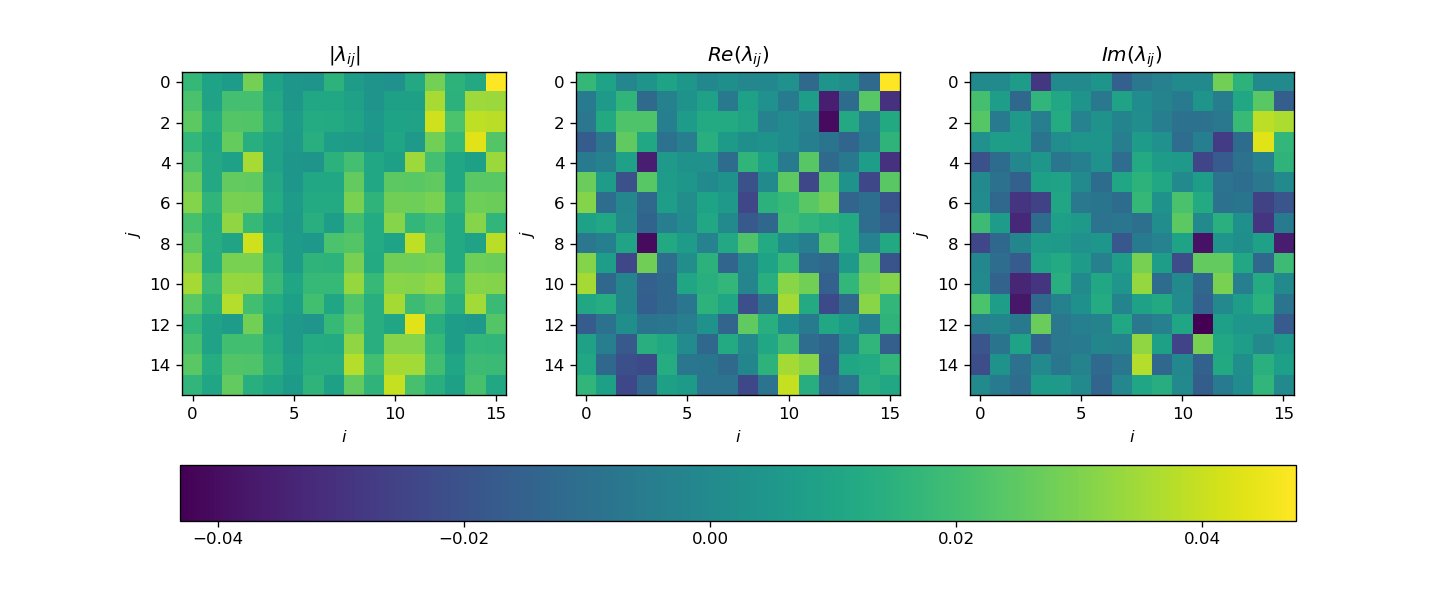

Ca a pris  0.3850095272064209 secondes


In [6]:
deb = time.time()
lambda_mat = tomo.fct_to_lambda(tomo._gate_from_U, nb_levels, draw_lambda = True, **param_test)
print("Ca a pris ", time.time() - deb, "secondes")

<IPython.core.display.Javascript object>


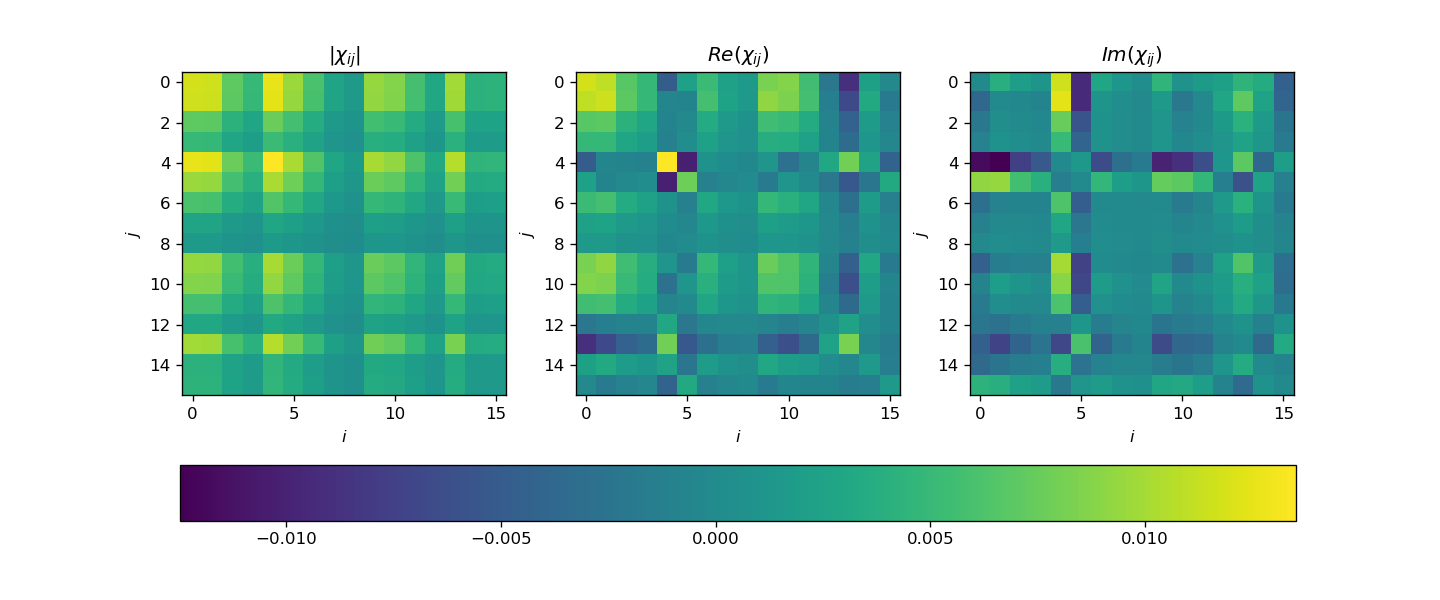

Ca a pris  0.26999688148498535 secondes


<IPython.core.display.Javascript object>


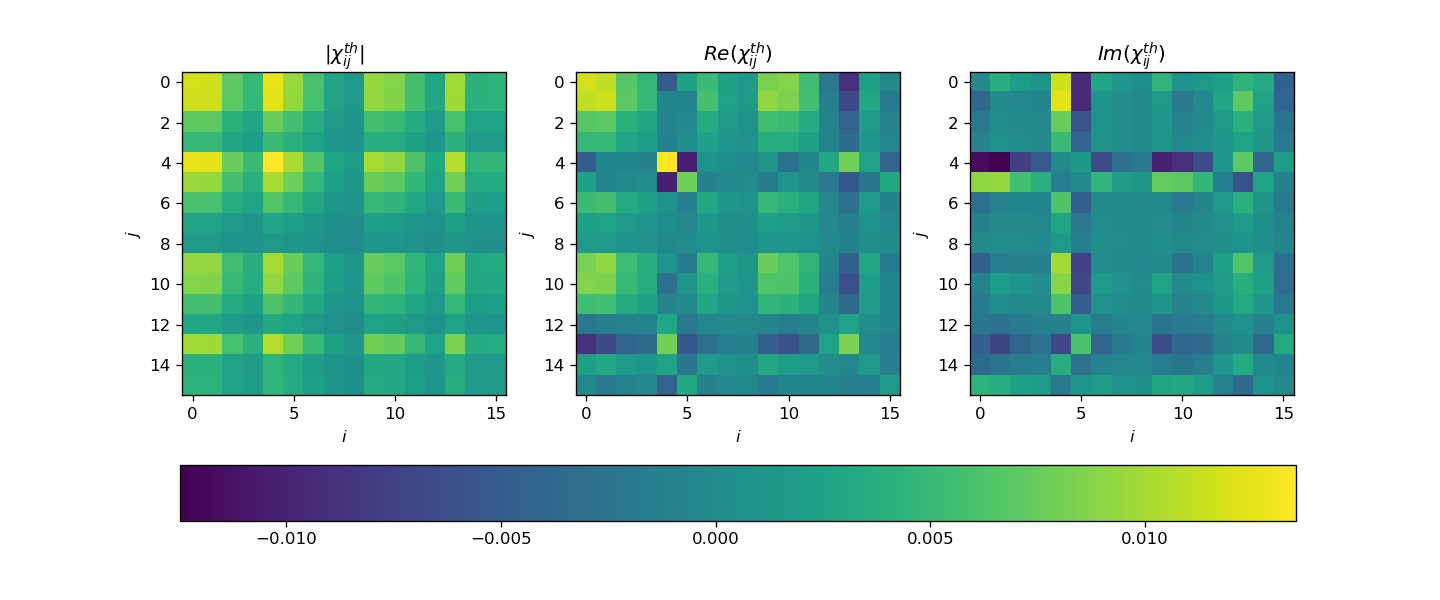

Ca a pris  180.90120553970337 secondes


In [7]:
deb = time.time()
chi_mat = tomo.lambda_to_chi(lambda_mat, nb_levels, draw_chi = True)
print("Ca a pris ", time.time() - deb, "secondes")


deb = time.time()
chi_th_mat = tomo.lambda_to_chi_beta(lambda_mat, nb_levels, draw_chi = True)
print("Ca a pris ", time.time() - deb, "secondes")



In [ ]:
deb = time.time()
chi_mat = fct_to_chi(gate_from_U, nb_levels, draw_chi, = True, **param_test)
print("It took : ", time.time() - deb ," seconds")

In [ ]:
#Sol CNOT
chi_sol_CNOT = np.zeros((16,16))
chi_sol_CNOT[:2, :2] = 1

chi_sol_CNOT[:2, 12] = 1
chi_sol_CNOT[:2, 13] = -1

chi_sol_CNOT[12, :2] = 1
chi_sol_CNOT[13, :2] = -1

chi_sol_CNOT[13,13] = 1
chi_sol_CNOT[12,12] = 1
chi_sol_CNOT[12,13] = -1
chi_sol_CNOT[13,12] = -1

draw_mat(chi_sol_CNOT, '\chi^{CNOT}')

## From Kraus

In [ ]:
# Examples of op_lists:
nb_levels = [2,2] #[2,2]
d = np.prod(nb_levels)

op_list_id = [qtp.qeye(dim)]


op_list_random = [qtp.Qobj(2*(np.random.rand(d, d)-.5) + 2j*(np.random.rand(d, d)-.5), 
                   dims = [nb_levels, nb_levels]) for i in range(d**2)]

op_list_xyz = [qtp.tensor(qtp.qeye(2), qtp.sigmax()), 
               qtp.tensor(qtp.qeye(2), qtp.sigmay()),
               qtp.tensor(qtp.qeye(2), qtp.sigmaz()),]

In [ ]:
op_list = op_list_xyz

print("Op_list_size is : ",len(op_list))

param_test = {
    'op_list' : op_list
}

# init_state_test = qtp.fock_dm(nb_levels, [0 for _ in nb_levels])
# gate_from_Kraus(init_state_test, **param_test)

In [ ]:
deb = time.time()
chi_mat = fct_to_chi(gate_from_Kraus, nb_levels = nb_levels, draw_chi = True, **param_test)
print("It took : ", time.time() - deb ," seconds")

In [ ]:
deb = time.time()
kraus_list = chi_to_kraus(chi_mat, nb_levels, draw_kraus = True)
print("It took : ", time.time() - deb ," seconds")

In [ ]:
deb = time.time()
_ = fct_to_chi(gate_from_Kraus, nb_levels = nb_levels, draw_chi = True, **{'op_list' : kraus_list})

In [ ]:
draw_mat_mult([op.full() for op in op_list], ["E^{"+str(i)+"}" for i in range(len(op_list))])

# draw_mat(op_list[0].full(), "E^0")

## Time analysis

In [ ]:
max_d_loc = 14
max_d = 7

tuples_prov = []
for d1 in range(2, max_d_loc):
    for d2 in range(2, max_d_loc):
        tuples_prov.append([d1*d2, d1, d2])

        
tuples_prov.sort()

list_nb_systs = []
for c in tuples_prov:
    if c[0]<max_d:
        list_nb_systs.append(c[1:])
        
list_nb_systs = list_nb_systs*1

print("List is ", len(list_nb_systs), "long")

In [ ]:
absc_fct_to_lambda = [c[0]*c[1] for c in list_nb_systs]
ord_fct_to_lambda = []
ord_lambda_to_chi = []
ord_chi_to_kraus  = []

estim = 0

In [ ]:
estim = sum(K_fct_to_lambda * absc_fct_to_lambda[i]**exp_fct_to_lambda +  \
                              K_lambda_to_chi * absc_fct_to_lambda[i]**exp_lambda_to_chi +  \
                              K_chi_to_kraus *  absc_fct_to_lambda[i]**exp_chi_to_kraus  for i in range(len(absc_fct_to_lambda)))

print("Estimation : ", estim, "seconds")

In [ ]:
#fct to lambda
print("It should take ", estim, "seconds and end around ", datetime.datetime.now() + datetime.timedelta(seconds = estim))

deb_all = time.time()

for i in range(len(list_nb_systs)):
    print(i, "th  d=" +str(absc_fct_to_lambda[i]), datetime.datetime.now())
    dic = { 'U' : qtp.Qobj(2*(np.random.rand(absc_fct_to_lambda[i], absc_fct_to_lambda[i])-.5) + \
                     2j*(np.random.rand(absc_fct_to_lambda[i], absc_fct_to_lambda[i])-.5), 
                   dims = [list_nb_systs[i], list_nb_systs[i]]).unit() }
    
    deb = time.time()
    lambda_mat = fct_to_lambda(gate_from_U, list_nb_systs[i], **dic)
    ord_fct_to_lambda.append(time.time() - deb)
    
    deb = time.time()
    chi_mat = lambda_to_chi(lambda_mat, list_nb_systs[i])
    ord_lambda_to_chi.append(time.time() - deb)
    
    deb = time.time()
    kraus_list = chi_to_kraus(chi_mat, list_nb_systs[i])
    ord_chi_to_kraus.append(time.time() - deb)
    
    
print("It all took ", time.time() - deb_all, " seconds")
# plt.scatter(absc_fct_to_lambda, ord_fct_to_lambda, label = 'fct to lambda')

In [ ]:
#On fait modelisation exponentielle (valeurs obtenues sur 6* la liste avec max à 12 
#(limité par complexité spaciale))

exp_fct_to_lambda = 3.57 #np.mean([(np.log(ord_fct_to_lambda[a]) - np.log(ord_fct_to_lambda[b]))/  \
#                              (np.log(absc_fct_to_lambda[a])-np.log(absc_fct_to_lambda[b])) 
#                               for a in range(len(ord_fct_to_lambda))
#                               for b in range(len(ord_chi_to_kraus)) if absc_fct_to_lambda[a]!=absc_fct_to_lambda[b]])

exp_lambda_to_chi = 8.03 #np.mean([(np.log(ord_lambda_to_chi[a]) - np.log(ord_lambda_to_chi[b]))/  \
#                              (np.log(absc_fct_to_lambda[a])-np.log(absc_fct_to_lambda[b])) 
#                               for a in range(len(ord_fct_to_lambda))
#                               for b in range(len(ord_chi_to_kraus)) if absc_fct_to_lambda[a]!=absc_fct_to_lambda[b]])

exp_chi_to_kraus = 2.42 #np.mean([(np.log(ord_chi_to_kraus[a]) - np.log(ord_chi_to_kraus[b]))/  \
#                             (np.log(absc_fct_to_lambda[a])-np.log(absc_fct_to_lambda[b])) 
#                               for a in range(len(ord_fct_to_lambda))
#                               for b in range(len(ord_chi_to_kraus)) if absc_fct_to_lambda[a]!=absc_fct_to_lambda[b]])


K_fct_to_lambda = .00155 #np.mean([ord_fct_to_lambda[a]/ absc_fct_to_lambda[a]**exp_fct_to_lambda
#                               for a in range(len(ord_fct_to_lambda))])

K_lambda_to_chi = 1e-6 #np.mean([ord_lambda_to_chi[a]/ absc_fct_to_lambda[a]**exp_lambda_to_chi
#                               for a in range(len(ord_fct_to_lambda))])

K_chi_to_kraus = .00053 #np.mean([ord_chi_to_kraus[a]/ absc_fct_to_lambda[a]**exp_chi_to_kraus
#                               for a in range(len(ord_fct_to_lambda))])

print("fct_to_lambda est environ en ", np.round(K_fct_to_lambda,5), "x d^", np.round(exp_fct_to_lambda, 2))
print("lambda_to_chi est environ en ", np.round(K_lambda_to_chi,6), "x d^", np.round(exp_lambda_to_chi, 2))
print("chi_to_kraus est environ en ", np.round(K_chi_to_kraus,5), "x d^", np.round(exp_chi_to_kraus, 2))


In [ ]:
N = 10000
fact_lgth = 5

fig, ax = plt.subplots(3,1, figsize = (12,15))

ax[0].scatter(absc_fct_to_lambda, ord_fct_to_lambda, label = 'exp data')
ax[0].plot(np.linspace(np.min(absc_fct_to_lambda), fact_lgth*np.max(absc_fct_to_lambda), N),
           np.linspace(np.min(absc_fct_to_lambda), fact_lgth*np.max(absc_fct_to_lambda), N)**exp_fct_to_lambda * K_fct_to_lambda, label = 'approx')
ax[0].set_title("fct_to_lambda run times")
ax[0].set_xlabel("d")
ax[0].set_ylabel("runtime")
# ax[0].set_yscale('log')
ax[0].legend()

ax[1].scatter(absc_fct_to_lambda, ord_lambda_to_chi, label = 'exp data')
ax[1].plot(np.linspace(np.min(absc_fct_to_lambda), fact_lgth*np.max(absc_fct_to_lambda), N),
           np.linspace(np.min(absc_fct_to_lambda), fact_lgth*np.max(absc_fct_to_lambda), N)**exp_lambda_to_chi * K_lambda_to_chi, label = 'approx')
ax[1].set_title("lambda_to_chi run times")
ax[1].set_xlabel("d")
ax[1].set_ylabel("runtime")
# ax[1].set_yscale('log')
ax[1].legend()

ax[2].scatter(absc_fct_to_lambda, ord_chi_to_kraus, label = 'exp data')
ax[2].plot(np.linspace(np.min(absc_fct_to_lambda), fact_lgth*np.max(absc_fct_to_lambda), N),
           np.linspace(np.min(absc_fct_to_lambda), fact_lgth*np.max(absc_fct_to_lambda), N)**exp_chi_to_kraus * K_chi_to_kraus, label = 'approx')
ax[2].set_title("chi_to_kraus run times")
ax[2].set_xlabel("d")
ax[2].set_ylabel("runtime")
# ax[2].set_yscale('log')
ax[2].legend()

### All in one (for .py)

In [ ]:
### tests complexity
# ##
# max_d_loc = 14
# max_d = 12
# 
# tuples_prov = []
# for d1 in range(2, max_d_loc):
#     for d2 in range(2, max_d_loc):
#         tuples_prov.append([d1*d2, d1, d2])
# 
#         
# tuples_prov.sort()
# 
# list_nb_systs = []
# for c in tuples_prov:
#     if c[0]<max_d:
#         list_nb_systs.append(c[1:])
#         
# list_nb_systs = list_nb_systs*7
# 
# print("List is ", len(list_nb_systs), "long")
# 
# ##
# absc_fct_to_lambda = [c[0]*c[1] for c in list_nb_systs]
# ord_fct_to_lambda = []
# ord_lambda_to_chi = []
# ord_chi_to_kraus  = []
# 
# # estim = 0
# 
# ##
# estim = sum(K_fct_to_lambda * absc_fct_to_lambda[i]**exp_fct_to_lambda +  \
#                               K_lambda_to_chi * absc_fct_to_lambda[i]**exp_lambda_to_chi +  \
#                               K_chi_to_kraus *  absc_fct_to_lambda[i]**exp_chi_to_kraus  for i in range(len(absc_fct_to_lambda)))
# 
# print("Estimation : ", estim, "seconds")
# 
# 
# #fct to lambda
# print("It should take ", estim, "seconds and end around ", datetime.datetime.now() + datetime.timedelta(seconds = estim))
# 
# ##
# deb_all = time.time()
# 
# for i in range(len(list_nb_systs)):
#     print(i, "th  d=" +str(absc_fct_to_lambda[i]), datetime.datetime.now())
#     dic = { 'U' : qtp.Qobj(2*(np.random.rand(absc_fct_to_lambda[i], absc_fct_to_lambda[i])-.5) + \
#                      2j*(np.random.rand(absc_fct_to_lambda[i], absc_fct_to_lambda[i])-.5), 
#                    dims = [list_nb_systs[i], list_nb_systs[i]]).unit() }
#     
#     
#     deb = time.time()
#     lambda_mat = fct_to_lambda(_gate_from_U, list_nb_systs[i], **dic)
#     ord_fct_to_lambda.append(time.time() - deb)
#     
#     deb = time.time()
#     chi_mat = lambda_to_chi(lambda_mat, list_nb_systs[i])
#     ord_lambda_to_chi.append(time.time() - deb)
#     
#     deb = time.time()
#     kraus_list = chi_to_kraus(chi_mat, list_nb_systs[i])
#     ord_chi_to_kraus.append(time.time() - deb)
#     
#     
# print("It all took ", time.time() - deb_all, " seconds")
# # plt.scatter(absc_fct_to_lambda, ord_fct_to_lambda, label = 'fct to lambda')
# 
# ##
# #On fait modelisation exponentielle
# 
# exp_fct_to_lambda = np.mean([(np.log(ord_fct_to_lambda[a]) - np.log(ord_fct_to_lambda[b]))/  \
#                              (np.log(absc_fct_to_lambda[a])-np.log(absc_fct_to_lambda[b])) 
#                               for a in range(len(ord_fct_to_lambda))
#                               for b in range(len(ord_chi_to_kraus)) if absc_fct_to_lambda[a]!=absc_fct_to_lambda[b]])
# 
# exp_lambda_to_chi = np.mean([(np.log(ord_lambda_to_chi[a]) - np.log(ord_lambda_to_chi[b]))/  \
#                              (np.log(absc_fct_to_lambda[a])-np.log(absc_fct_to_lambda[b])) 
#                               for a in range(len(ord_fct_to_lambda))
#                               for b in range(len(ord_chi_to_kraus)) if absc_fct_to_lambda[a]!=absc_fct_to_lambda[b]])
# 
# exp_chi_to_kraus = np.mean([(np.log(ord_chi_to_kraus[a]) - np.log(ord_chi_to_kraus[b]))/  \
#                             (np.log(absc_fct_to_lambda[a])-np.log(absc_fct_to_lambda[b])) 
#                               for a in range(len(ord_fct_to_lambda))
#                               for b in range(len(ord_chi_to_kraus)) if absc_fct_to_lambda[a]!=absc_fct_to_lambda[b]])
# 
# 
# K_fct_to_lambda = np.mean([ord_fct_to_lambda[a]/ absc_fct_to_lambda[a]**exp_fct_to_lambda
#                               for a in range(len(ord_fct_to_lambda))])
# 
# K_lambda_to_chi = np.mean([ord_lambda_to_chi[a]/ absc_fct_to_lambda[a]**exp_lambda_to_chi
#                               for a in range(len(ord_fct_to_lambda))])
# 
# K_chi_to_kraus = np.mean([ord_chi_to_kraus[a]/ absc_fct_to_lambda[a]**exp_chi_to_kraus
#                               for a in range(len(ord_fct_to_lambda))])
# 
# print("fct_to_lambda est environ en ", np.round(K_fct_to_lambda,5), "x t^", np.round(exp_fct_to_lambda, 2))
# print("lambda_to_chi est environ en ", np.round(K_lambda_to_chi,6), "x t^", np.round(exp_lambda_to_chi, 2))
# print("chi_to_kraus est environ en ", np.round(K_chi_to_kraus,5), "x t^", np.round(exp_chi_to_kraus, 2))
# 
# 
# 
# ##
# N = 10000
# fact_lgth = 1.3
# 
# plt.figure()
# plt.scatter(absc_fct_to_lambda, ord_fct_to_lambda, label = 'exp data')
# plt.plot(np.linspace(np.min(absc_fct_to_lambda), fact_lgth*np.max(absc_fct_to_lambda), N),
#            np.linspace(np.min(absc_fct_to_lambda), fact_lgth*np.max(absc_fct_to_lambda), N)**exp_fct_to_lambda * K_fct_to_lambda, label = 'approx')
# plt.title("fct_to_lambda run times")
# plt.xlabel("d")
# plt.ylabel("runtime")
# # plt.yscale('log')
# plt.legend()
# 
# plt.figure()
# plt.scatter(absc_fct_to_lambda, ord_lambda_to_chi, label = 'exp data')
# plt.plot(np.linspace(np.min(absc_fct_to_lambda), fact_lgth*np.max(absc_fct_to_lambda), N),
#            np.linspace(np.min(absc_fct_to_lambda), fact_lgth*np.max(absc_fct_to_lambda), N)**exp_lambda_to_chi * K_lambda_to_chi, label = 'approx')
# plt.title("lambda_to_chi run times")
# plt.xlabel("d")
# plt.ylabel("runtime")
# # plt.yscale('log')
# plt.legend()
# 
# plt.figure()
# plt.scatter(absc_fct_to_lambda, ord_chi_to_kraus, label = 'exp data')
# plt.plot(np.linspace(np.min(absc_fct_to_lambda), fact_lgth*np.max(absc_fct_to_lambda), N),
#            np.linspace(np.min(absc_fct_to_lambda), fact_lgth*np.max(absc_fct_to_lambda), N)**exp_chi_to_kraus * K_chi_to_kraus, label = 'approx')
# plt.title("chi_to_kraus run times")
# plt.xlabel("d")
# plt.ylabel("runtime")
# # plt.yscale('log')
# plt.legend()
# 
# plt.show()


# ?